# Part 5: Modeling Content-based Filtering with DecisionTreeClassifier and Tfidf and PCA
---
- Importing the relevant libraries first...

In [1]:
#import requests
import random
#import time
import numpy as np
import pandas as pd
#from bs4 import BeautifulSoup as bs
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Importing X_legit and y which contain the shops that userid 2043 rated and ratings respectively
---

In [2]:
X_legit = pd.read_csv('yelp_data/xlegit.csv')
X_legit.shape

(980, 19307)

In [3]:
y = pd.read_csv('yelp_data/y.csv', squeeze=True)
y.head()

0    4.0
1    4.0
2    5.0
3    5.0
4    4.0
Name: user_rating, dtype: float64

In [4]:
#split the dataset into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(X_legit, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
y_train.value_counts(normalize=True)

4.0    0.479592
5.0    0.383929
3.0    0.118622
2.0    0.012755
1.0    0.005102
Name: user_rating, dtype: float64

<ul>
    
- The baseline accuracy will be 0.48 since that is the highest proportion among the training dataset's target classes

In [6]:
#instantiate scaler since not all of the features are of the same scale, eg. review_count and avg_store_rating
ss = StandardScaler()

In [7]:
#fitting the train and transforming both the train and test sets
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [8]:
# Instantiate the PCA model
pca = PCA(random_state=42,n_components=50)

In [9]:
# Fit the model
pca.fit(X_train_sc)

# Transform the data
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [10]:
# #this is for initial decision trees tuned
# params = {
#     'max_depth':[3,5,7,10],
#     'min_samples_split':[5, 10, 15, 20],
#     'min_samples_leaf':[2, 3, 4, 5, 6, 7],
#     'class_weight':['balanced']
#     } 

In [11]:
#dtcpca_gridsearch = GridSearchCV(dtc_model_pca, params, cv = 10, verbose = 1, n_jobs = -1)
#dtcpca_gridsearch.fit(X_train_pca, y_train)

In [12]:
#print('Gridsearch best score: ', dtcpca_gridsearch.best_score_)
#print('Gridsearch best estimator: ', dtcpca_gridsearch.best_estimator_)
#print('Gridsearch best score on test set: ', dtcpca_gridsearch.best_estimator_.score(X_test_pca,y_test))

In [13]:
#loading the model tuned from before (the 3 cells above) here for implementation of the rest of the code in this notebook
loaded_model = joblib.load('yelp_data/dtcpca_model.sav')

In [14]:
#looking at the accuracy score of tuned model on test set
loaded_model.best_estimator_.score(X_test_pca,y_test)

0.4336734693877551

<ul>
    
- The tuned decisiontreeclassifier tfidf PCA model performed worse than random guessing with an accuracy of 0.43 that is also worse than baseline accuracy of 0.48..

In [15]:
#looking at the tuned model's best params
loaded_model.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [16]:
# Instantiate the model
#dtc_model_pca = DecisionTreeClassifier()

In [17]:
#saving previously tuned model for retrieval above, model has been moved to ./yelp_data-1
#filename = 'dtcpca_model.sav'

In [18]:
#saving previously tuned model for retrieval above, model has been moved to ./yelp_data-1
#joblib.dump(dtcpca_gridsearch,filename)

## Formulating recommendations for userid 2043 based on DecisionTreeClassifier model with tfidf and PCA
---

In [19]:
#stacking X_test as first step in regenerating the shops column for predictions
trial = X_test.stack()

In [20]:
#creating loop to re-generate original X_test order of shops
index_lst = []
outlets_lst = []
for n in range(len(trial.index)):
    if trial.index[n][1].startswith('shops_') and trial[n]!=0:
        index_lst.append(str(trial.index[n][0]))
        outlets_lst.append(trial.index[n][1])
index_lst = [int(x) for x in index_lst]
reconstructed_X_test = pd.DataFrame({'shops':outlets_lst}, index=index_lst)

In [21]:
#creating column of rating predictions
rating_predictions = loaded_model.best_estimator_.predict(X_test_pca)

In [22]:
#adding column of rating predictions into reconstructed df
reconstructed_X_test['predicted_ratings']=rating_predictions

In [23]:
#checking the reconstructed df out after including the rating predictions' column...
reconstructed_X_test.head()

,shops,predicted_ratings
292,shops_got-luck-cafe-singapore,4.0
748,shops_symmetry-singapore,4.0
780,shops_the-bread-project-singapore,4.0
213,shops_dean-and-deluca-singapore-4,4.0
689,shops_stack-singapore,4.0


In [24]:
#adding the actual ratings into the reconstructed df for comparison later on...
reconstructed_X_test['actual_ratings']=y_test

In [25]:
#top 5 recommendations for userid 2043 based on content-based filtering (using decision tree classifier) predictions
reconstructed_X_test.sort_values('predicted_ratings', ascending=False).head(5)

,shops,predicted_ratings,actual_ratings
477,shops_meidi-ya-singapore-2,5.0,5.0
434,shops_lavender-food-hub-singapore,5.0,5.0
396,shops_killiney-kopitiam-singapore-4,5.0,5.0
265,shops_food-for-thought-singapore,5.0,4.0
626,shops_rabbit-carrot-gun-singapore-2,5.0,4.0


## Defining functions for evaluation of model
---

In [26]:
#defining function for obtaining tn, fp, fn, tp for each rating class for feeding into micro-avg precision and recall functions defined below
def cm_spec(y_true,y_pred,rating,state):
    if state=='tn':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][0]
    elif state=='fp':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][1]
    elif state=='fn':
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][0]
    else:
        return multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][1]
    

In [27]:
#defining function for obtaining micro-avg precision
def micro_avg_precision(y_true,y_pred):
    return ((cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp'))/(
                                                cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp')+
                                                cm_spec(y_true,y_pred,1,'fp')+
                                                 cm_spec(y_true,y_pred,2,'fp')+
                                                 cm_spec(y_true,y_pred,3,'fp')+
                                                 cm_spec(y_true,y_pred,4,'fp')+
                                                 cm_spec(y_true,y_pred,5,'fp')))

In [28]:
#defining function for obtaining micro-avg recall
def micro_avg_recall(y_true,y_pred):
    return ((cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp'))/(
                                                cm_spec(y_true,y_pred,1,'tp')+
                                                 cm_spec(y_true,y_pred,2,'tp')+
                                                 cm_spec(y_true,y_pred,3,'tp')+
                                                 cm_spec(y_true,y_pred,4,'tp')+
                                                 cm_spec(y_true,y_pred,5,'tp')+
                                                cm_spec(y_true,y_pred,1,'fn')+
                                                 cm_spec(y_true,y_pred,2,'fn')+
                                                 cm_spec(y_true,y_pred,3,'fn')+
                                                 cm_spec(y_true,y_pred,4,'fn')+
                                                 cm_spec(y_true,y_pred,5,'fn')))

In [29]:
#defining function for obtaining micro_avg_f1
def micro_avg_f1(y_true,y_pred):
    return 2 * ((micro_avg_precision(y_true,y_pred) * micro_avg_recall(y_true,y_pred))/(micro_avg_precision(y_true,y_pred) + micro_avg_recall(y_true,y_pred)))

In [30]:
#function to print out confusion matrix breakdown for each rating class
def confusion_breakdown(y_true,y_pred,rating):
    print("True negatives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][0]))
    print("False positives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][0][1]))
    print("False negatives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][0]))
    print("True positives for rating {}: {}".format(
        rating,multilabel_confusion_matrix(y_true,y_pred)[rating-1][1][1]))
    return "******************************************"

In [31]:
print(confusion_breakdown(y_test,rating_predictions,1))
print(confusion_breakdown(y_test,rating_predictions,2))
print(confusion_breakdown(y_test,rating_predictions,3))
print(confusion_breakdown(y_test,rating_predictions,4))
print(confusion_breakdown(y_test,rating_predictions,5))

True negatives for rating 1: 188
False positives for rating 1: 7
False negatives for rating 1: 1
True positives for rating 1: 0
******************************************
True negatives for rating 2: 191
False positives for rating 2: 2
False negatives for rating 2: 3
True positives for rating 2: 0
******************************************
True negatives for rating 3: 153
False positives for rating 3: 20
False negatives for rating 3: 18
True positives for rating 3: 5
******************************************
True negatives for rating 4: 61
False positives for rating 4: 41
False negatives for rating 4: 50
True positives for rating 4: 44
******************************************
True negatives for rating 5: 80
False positives for rating 5: 41
False negatives for rating 5: 39
True positives for rating 5: 36
******************************************


In [32]:
#the model wasn't able to predict most of the ratings well comparing this to the tn, fp, fn, tp count above...
y_test.value_counts()

4.0    94
5.0    75
3.0    23
2.0     3
1.0     1
Name: user_rating, dtype: int64

In [33]:
print("Gridsearched DecisionTreeClassifier with tfidf and PCA balanced class_weight yielded ", micro_avg_precision(y_test,rating_predictions))

Gridsearched DecisionTreeClassifier with tfidf and PCA balanced class_weight yielded  0.4336734693877551


In [34]:
print("Gridsearched DecisionTreeClassifier with tfidf and PCA balanced class_weight yielded ", micro_avg_recall(y_test,rating_predictions))

Gridsearched DecisionTreeClassifier with tfidf and PCA balanced class_weight yielded  0.4336734693877551


In [35]:
print("Gridsearched DecisionTreeClassifier with tfidf and PCA balanced class_weight yielded micro_avg_f1 of ", micro_avg_f1(y_test,rating_predictions))

Gridsearched DecisionTreeClassifier with tfidf and PCA balanced class_weight yielded micro_avg_f1 of  0.4336734693877551


In [36]:
#poor precision, recall, and f1 scores for all rating classes!
print(classification_report(y_test,rating_predictions))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         3
         3.0       0.20      0.22      0.21        23
         4.0       0.52      0.47      0.49        94
         5.0       0.47      0.48      0.47        75

    accuracy                           0.43       196
   macro avg       0.24      0.23      0.23       196
weighted avg       0.45      0.43      0.44       196



## Calculating and plotting the multiclass ROC AUC as part of model evaluation
---


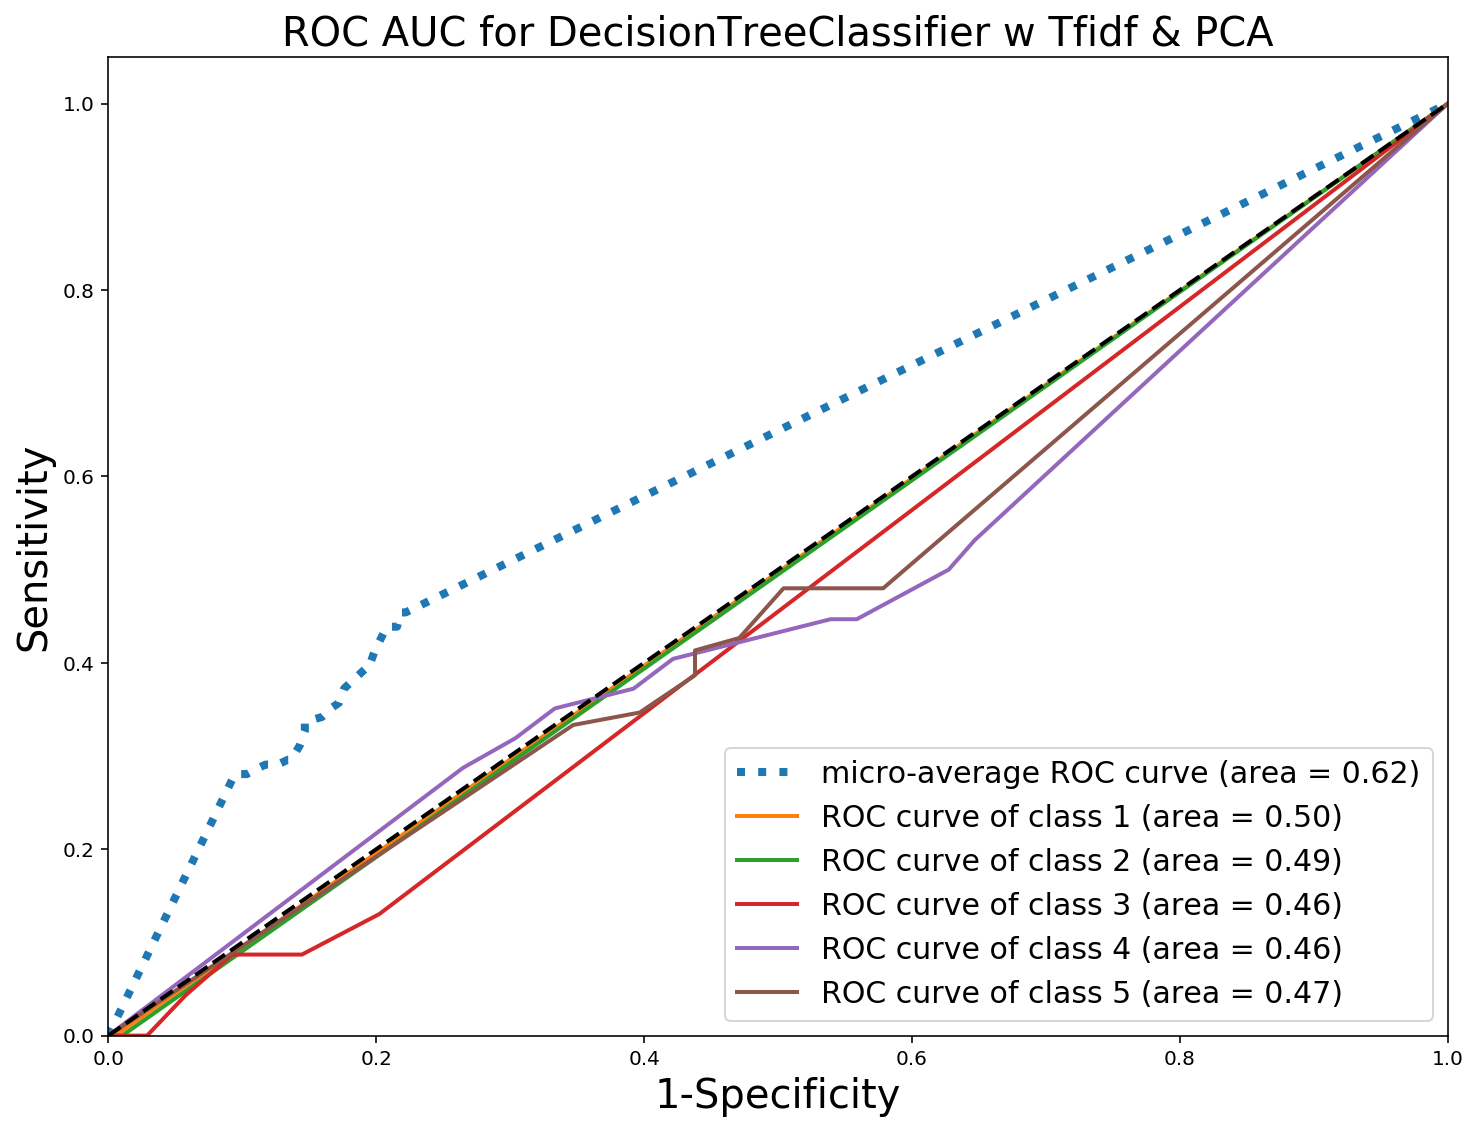

In [37]:
#making a copy of X_legit and y for computation and plotting of ROC AUC for the respective rating classes and micro-average
X_copy = X_legit.copy()

y_copy = y.copy()

# Binarize the output
y_copy = label_binarize(y_copy, classes=[1.0, 2.0, 3.0, 4.0, 5.0])
n_classes = y_copy.shape[1]

# shuffle and split training and test sets
X_copy_train, X_copy_test, y_copy_train, y_copy_test = train_test_split(X_copy, y_copy, test_size=0.2,
                                                    random_state=42, stratify=y_copy)

#instantiate scaler since not all of the features are of the same scale, eg. review_count and avg_store_rating
ss1 = StandardScaler()

#fitting the train and transforming both the train and test sets
X_copy_train_sc = ss1.fit_transform(X_copy_train)
X_copy_test_sc = ss1.transform(X_copy_test)

# Instantiate the PCA model
pca = PCA(random_state=42,n_components=50)

# Fit the PCA model
pca.fit(X_copy_train_sc)

# Transform the data
X_copy_train_sc_pca = pca.transform(X_copy_train_sc)
X_copy_test_sc_pca = pca.transform(X_copy_test_sc)

# Learn to predict each class against the other using the params of tuned model with random_state set to 42 so that the values and curves do not waver
classifier = OneVsRestClassifier(DecisionTreeClassifier(class_weight='balanced',max_depth=10,min_samples_leaf=3,min_samples_split=5, random_state=42))
y_score = classifier.fit(X_copy_train_sc_pca, y_copy_train).predict_proba(X_copy_test_sc_pca)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_copy_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_copy_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves and micro-averaged one
plt.figure(figsize=(12,9))
lw=2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('ROC AUC for DecisionTreeClassifier w Tfidf & PCA',fontsize=20)
plt.legend(loc="lower right",fontsize=15)
plt.show()

In [38]:
#calculating one-vs-one and one-vs-rest micro-averaged ROC AUC to check if there is a difference between both
y_prob = classifier.predict_proba(X_copy_test_sc_pca)
micro_roc_auc_ovo = roc_auc_score(y_copy_test, y_prob, multi_class="ovo",
                                     average="micro")
micro_roc_auc_ovr = roc_auc_score(y_copy_test, y_prob, multi_class="ovr",
                                     average="micro")
print("One-vs-One ROC AUC score:\n{:.6f} "
      "(micro-averaged)"
      .format(micro_roc_auc_ovo))
print("One-vs-Rest ROC AUC score:\n{:.6f} "
      "(micro-averaged)"
      .format(micro_roc_auc_ovr))

One-vs-One ROC AUC score:
0.623331 (micro-averaged)
One-vs-Rest ROC AUC score:
0.623331 (micro-averaged)


In [39]:
#calculating one-vs-one and one-vs-rest ROC AUC weighted by prevalence to check if there is a difference between both
y_prob = classifier.predict_proba(X_copy_test_sc_pca)
weighted_roc_auc_ovo = roc_auc_score(y_copy_test, y_prob, multi_class="ovo",
                                     average="weighted")
weighted_roc_auc_ovr = roc_auc_score(y_copy_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC score:\n{:.6f} "
      "(weighted by prevalence)"
      .format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC score:\n{:.6f} "
      "(weighted by prevalence)"
      .format(weighted_roc_auc_ovr))

One-vs-One ROC AUC score:
0.465711 (weighted by prevalence)
One-vs-Rest ROC AUC score:
0.465711 (weighted by prevalence)


## Model Summary and Result Interpretation
---

<ul>
    
- Tuned DecisionTreeClassifier with tfidf and PCA performed poorly, worse than LogReg with PCA as it predicts all ratings almost about as likely as random guessing as evidenced by both the classification report and the multiclass ROC AUC plots and scores above.
- Accuracy of 0.43, Micro-Averaged precision of 0.43, Micro-Averaged recall of 0.43, Micro-Averaged $F_1$ of 0.43
- Micro-Averaged ROC AUC of 0.62, weighted by prevalence ROC AUC of 0.47